<a href="https://colab.research.google.com/github/camlab-bioml/2021_IMC_Jett/blob/main/DAMM_081221.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import torch
import torch.optim as optim
import torch.distributions as D
import torch.nn.functional as F

import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

from matplotlib.backends.backend_pdf import PdfPages

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

import seaborn as sns

%matplotlib inline

In [37]:
%pip install scanpy

In [38]:
import scanpy as sc
adata = sc.read_h5ad("basel_zuri_subsample.h5ad")

cell_sel = np.random.choice(adata.shape[0], size=1000)
adata = adata[cell_sel,:]

In [39]:
# ## generate data
# def generateData(n_clusters = 3, n_obs = 10000, n_features = 2):

#   #n_clusters = 3; n_obs = 100; n_features = 2
  
#   ## set truth expression means/covariances (multivariate) ##
#   mu = np.random.rand(n_clusters, n_features)
#   # mu = np.sort(mu, 0) ## sort expressions
#   sigma = 0.001 * np.identity(n_features) ## variance-covariance matrix

#   ## set truth cell size means/variances (univariate) ##
#   psi = [np.random.normal(100, 25) for i in range(n_clusters)]
#   #psi = np.arange(90, 90 + 5 * n_clusters, 5)
#   psi = np.sort(psi, 0)
#   omega = 1 ## standard deviation
#   ###

#   ## set latent variables distributions ##
#   lambda_arr = np.random.binomial(1, .95, n_obs) # p=.95 (a cell belongs to singlet or doublet) 

#   n_singlet = np.sum(lambda_arr == 1) ## number of cells in singlet clusters
#   n_doublet = np.sum(lambda_arr == 0) ## number of cells in doublet clusters
  
#   lambda0_arr = n_singlet / n_obs ## proportion of cells belong to singlet
#   lambda1_arr = n_doublet / n_obs ## proportion of cells belong to doublet

#   #pi_arr = np.sort(np.random.sample(n_clusters))
#   pi_arr = np.sort(np.random.rand(n_clusters))
#   pi_arr /= pi_arr.sum()

#   n_doublet_clusters = int((n_clusters * n_clusters - n_clusters)/2 + n_clusters)
#   #tau_arr = np.sort(np.random.sample(n_doublet_clusters))
#   tau_arr = np.sort(np.random.rand(n_doublet_clusters))
#   tau_arr /= tau_arr.sum()

#   ## draw cells based on defined parameters theta1 = (mu, sigma, psi, omega) & theta2 = (lambda, pi, tau)
#   x = np.zeros((n_singlet, n_features+5))
#   for i in range(n_singlet):
#     selected_cluster = np.random.choice(n_clusters, size = 1, p = pi_arr)[0] ## select a single cell cluster
#     x[i] = np.append(np.random.multivariate_normal(mu[selected_cluster], sigma),
#                      [np.random.normal(psi[selected_cluster], omega), 
#                       0, selected_cluster, 0, selected_cluster + n_doublet_clusters])
  
#   x[x < 0] = 1e-4
#   lookups = np.triu_indices(n_clusters) # wanted indices
#   xx = np.zeros((n_doublet, n_features+5))
#   for i in range(n_doublet):
#     selected_cluster = np.random.choice(n_doublet_clusters, p = tau_arr)

#     indx1 = lookups[0][selected_cluster]
#     indx2 = lookups[1][selected_cluster]

#     xx[i] = np.append(np.random.multivariate_normal( (mu[indx1] + mu[indx2])/2, (sigma + sigma)/2 ),
#                      [np.random.normal( (psi[indx1] + psi[indx2]), omega+omega ), 
#                       1, indx1, indx2, selected_cluster])
#   xx[xx < 0] = 1e-4
#   xxx = np.append(x, xx).reshape(n_obs, n_features+5)

#   return torch.tensor(xxx[:,:n_features]), torch.tensor(xxx[:,n_features]), torch.tensor(xxx), [mu, sigma, psi, omega], [lambda0_arr, pi_arr, tau_arr]

In [40]:
YY = adata.X
SS = adata.obs.Area

nc = 8 # number of clusters?
nf = YY.shape[1]
no = YY.shape[0]

YY = np.arcsinh(YY / 5.)

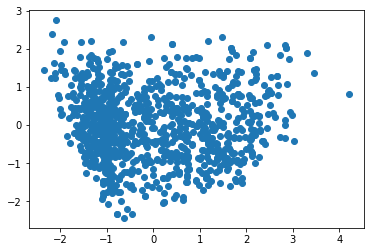

In [41]:
pca = PCA(n_components=2)
Z = pca.fit_transform(YY)

plt.scatter(Z[:,0], Z[:,1]);

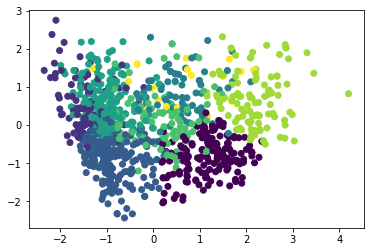

In [42]:
N_INIT = 5

kms = [KMeans(nc).fit(YY) for i in range(N_INIT)]
inertias = [k.inertia_ for k in kms]
km = kms[np.argmin(np.array(inertias))]
init_labels = km.labels_

plt.scatter(Z[:,0], Z[:,1], c=init_labels);

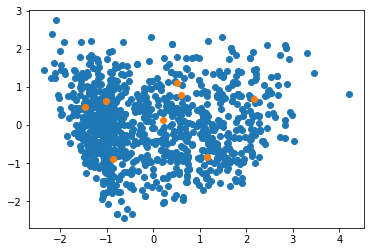

In [43]:
mu_init = np.array([YY[init_labels == i,:].mean(0) for i in np.unique(init_labels)])
sigma_init = np.array([YY[init_labels == i,:].std(0) for i in np.unique(init_labels)])
psi_init = np.array([SS[init_labels == i].mean() for i in np.unique(init_labels)])
omega_init = np.array([SS[init_labels == i].std() for i in np.unique(init_labels)])
pi_init = np.array([np.mean(init_labels == i) for i in np.unique(init_labels)])
tau_init = np.ones((nc,nc))
tau_init = tau_init / tau_init.sum()

Z_mu_init = pca.transform(mu_init)

plt.scatter(Z[:,0], Z[:,1]);
plt.scatter(Z_mu_init[:,0], Z_mu_init[:,1]);

In [44]:
def compute_p_y_given_z(Y, Theta):
  """ Returns NxC
  p(y_n | z_n = c)
  """
  mu = torch.exp(Theta['log_mu'])
  sigma = torch.exp(Theta['log_sigma']) + 1e-6

  dist_Y = D.Normal(mu, sigma)
  return dist_Y.log_prob(Y.reshape(no, 1, nf)).sum(2) # <- sum because IID over G

def compute_p_s_given_z(S, Theta):
  """ Returns NxC
  p(s_n | z_n = c)
  """
  psi = torch.exp(Theta['log_psi'])
  omega = torch.exp(Theta['log_omega'])  + 1e-6

  dist_S = D.Normal(psi, omega)
  return dist_S.log_prob(S.reshape(-1,1)) 

def compute_p_y_given_gamma(Y, Theta):
  """ NxCxC
  p(y_n | gamma_n = [c,c'])
  """

  mu = torch.exp(Theta['log_mu'])
  sigma = torch.exp(Theta['log_sigma'])  + 1e-6

  mu2 = mu.reshape(1, nc, nf)
  mu2 = (mu2 + mu2.permute(1, 0, 2)) / 2.0 # C x C x G matrix 

  sigma2 = sigma.reshape(1, nc, nf)
  sigma2 = (sigma2 + sigma2.permute(1,0,2)) / 2.0

  dist_Y2 = D.Normal(mu2, sigma2)
  return  dist_Y2.log_prob(Y.reshape(-1, 1, 1, nf)).sum(3) # <- sum because IID over G

def compute_p_s_given_gamma(Y, Theta):
  """ NxCxC
  p(y_n | gamma_n = [c,c'])
  """
  psi = torch.exp(Theta['log_psi'])
  omega = torch.exp(Theta['log_omega'])  + 1e-6

  psi2 = psi.reshape(-1,1)
  psi2 = psi2 + psi2.T

  omega2 = omega.reshape(-1,1)
  omega2 = omega2 + omega2.T

  dist_S2 = D.Normal(psi2, omega2)
  return dist_S2.log_prob(S.reshape(-1, 1, 1))

def compute_r_v_2(Y, S, Theta):
  """Need to compute
  p(gamma = [c,c'], d= 1 | Y,S)
  p(z = c, d=0 | Y,S)
  """
  log_pi = F.log_softmax(Theta['is_pi'])
  log_tau = F.log_softmax(Theta['is_tau'].reshape(-1)).reshape(nc,nc)
  log_delta = F.log_softmax(Theta['is_delta'])

  p_y_given_z = compute_p_y_given_z(Y, Theta)
  p_s_given_z = compute_p_s_given_z(S, Theta)

  p_data_given_z_d0 = p_y_given_z + p_s_given_z + log_pi
  p_data_given_d0 = torch.logsumexp(p_data_given_z_d0, dim=1) # this is p(data|d=0)

  p_y_given_gamma = compute_p_y_given_gamma(Y, Theta)
  p_s_given_gamma = compute_p_s_given_gamma(Y, Theta)

  p_data_given_gamma_d1 = (p_y_given_gamma + p_s_given_gamma + log_tau).reshape(no, -1)

  # p_data_given_d1 = torch.logsumexp(p_data_given_gamma_d1, dim=1)

  p_data = torch.cat([p_data_given_z_d0 + log_delta[0], p_data_given_gamma_d1 + log_delta[1]], dim=1)
  p_data = torch.logsumexp(p_data, dim=1)

  r = p_data_given_z_d0.T + log_delta[0] - p_data
  v = p_data_given_gamma_d1.T + log_delta[1] - p_data

  p_singlet = torch.exp(p_data_given_d0 + log_delta[0] - p_data)

  return r.T, v.T.reshape(-1,nc,nc), p_data, p_singlet


In [45]:
def Q(Theta, Y, S, r, v, ignored_indices):

  log_pi = F.log_softmax(Theta['is_pi'])
  log_tau = F.log_softmax(Theta['is_tau'].reshape(-1)).reshape(nc,nc)
  log_delta = F.log_softmax(Theta['is_delta'])

  p_y_given_z = compute_p_y_given_z(Y, Theta)
  p_s_given_z = compute_p_s_given_z(S, Theta)

  log_rd0z = p_s_given_z + p_y_given_z + log_pi + log_delta[0]

  p_y_given_gamma = compute_p_y_given_gamma(Y, Theta)
  p_s_given_gamma = compute_p_s_given_gamma(Y, Theta)

  log_rd1g = p_y_given_gamma + p_s_given_gamma + log_tau + log_delta[1]


  q1 = log_rd0z * r.exp()
  q2 = log_rd1g * v.exp()

  return q1.sum() + q2.sum()

def LL(Theta, v):
    """
    returns L(\mathbf\Theta, \mathbf{Y}, \mathbf{s}, \mathbf{r}, \mathbf{v})
    """
    l1 = rd0z.T + r
    l2 = rd1g[~ignored_indices].T + v[:,~ignored_indices]; #l2[torch.isinf(l2)] = -100
    ll = torch.vstack((torch.logsumexp(l1,1), torch.logsumexp(l2,1))).logsumexp(0).mean()

    return ll

In [46]:
# [lambda_d0, pi, tau, psi, omega, mu, sigma]
"""
Theta has order:
1) lambda_d0
2) pi
3) tau
4) psi
5) omega
6) mu
7) sigma
"""

## Helper functions:

def inverse_sigmoid(x):
  return -np.log((1 / (x + 1e-8)) - 1)

## Exact Theta:
# Theta = {
#     'log_mu': np.log(mu_init),
#     'log_sigma': np.log(sigma_init),
#     'log_psi': np.log(psi_init),
#     'log_omega': np.log(omega_init),
#     "is_delta": np.log([0.95, 1-0.95]),
#     'is_pi': np.log(pi_init),
#     'is_tau': np.log(tau_init)
# }

## Very slightly corrupted theta:
Theta = {
    'log_mu': np.log(mu_init + 1e-6),
    'log_sigma': np.log(sigma_init + 1e-6), #np.zeros_like(sigma_init),
    'log_psi': np.log(psi_init + 1e-6),
    'log_omega': np.log(omega_init + 1e-6),
    "is_delta": np.log([0.95, 1-0.95]),
    'is_pi': np.log(pi_init),
    'is_tau': np.log(tau_init)
}

Theta

{'is_delta': array([-0.05129329, -2.99573227]),
 'is_pi': array([-1.70925825, -2.25379493, -1.54646311, -2.60369019, -1.69281952,
        -2.19822508, -2.20727491, -3.81671283]),
 'is_tau': array([[-4.15888308, -4.15888308, -4.15888308, -4.15888308, -4.15888308,
         -4.15888308, -4.15888308, -4.15888308],
        [-4.15888308, -4.15888308, -4.15888308, -4.15888308, -4.15888308,
         -4.15888308, -4.15888308, -4.15888308],
        [-4.15888308, -4.15888308, -4.15888308, -4.15888308, -4.15888308,
         -4.15888308, -4.15888308, -4.15888308],
        [-4.15888308, -4.15888308, -4.15888308, -4.15888308, -4.15888308,
         -4.15888308, -4.15888308, -4.15888308],
        [-4.15888308, -4.15888308, -4.15888308, -4.15888308, -4.15888308,
         -4.15888308, -4.15888308, -4.15888308],
        [-4.15888308, -4.15888308, -4.15888308, -4.15888308, -4.15888308,
         -4.15888308, -4.15888308, -4.15888308],
        [-4.15888308, -4.15888308, -4.15888308, -4.15888308, -4.15888308,

In [47]:
Theta = {k: torch.tensor(v, requires_grad=True) for (k,v) in Theta.items()}

In [48]:
Theta['is_delta'].requires_grad = False

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to 

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


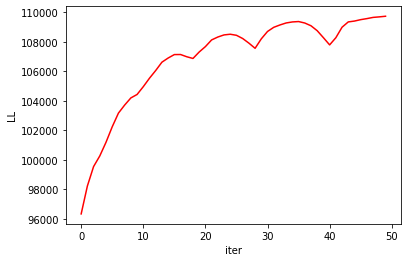

In [49]:
N_ITER_EM = 50
N_ITER_OPT = 100
lr = 1e-3
tol = 1e-4

  
ls = []
qs = []

Y = torch.tensor(YY)
S = torch.tensor(SS)

# Y, S, XX, theta0, theta1 = generateData(nc, no, nf)


# Theta now Theta.values()
# opt = optim.Adam([Theta['log_mu']], lr=lr)
opt = optim.Adam(Theta.values(), lr=lr)
for i in range(N_ITER_EM):

  print(i)

  opt.zero_grad()

  # E Step:
  with torch.no_grad():
    r,v,L, p_singlet = compute_r_v_2(Y, S, Theta)
    # if i == 0:
    #   print(LL(Theta, rd0z, r, rd1g, v, ignored_indices))

  # M step (i.e. maximizing Q):
  for j in range(N_ITER_OPT):

    q = -Q(Theta, Y, S, r, v, None)
    # print(q)
    q.backward()
    opt.step()

    # n_c = torch.sum(torch.exp(r), dim=0)
    # Theta[1] = n_c / no #lambda_d0
    # Theta[0] = torch.sum(Theta[1]) #pi
    # #print(Theta[1])

    # n_cc = torch.sum(torch.exp(v).reshape(no, nc, nc), dim=0)
    # Theta[2] = n_cc / no #tau

  # Check for convergence
  with torch.no_grad():
    # ll = LL(Theta, rd0z, r, rd1g, v, ignored_indices)
    ll = q.detach() # Q(Theta, Y, S, r, v, None)
  
    #if i > 0 and abs(ls[-1] - ll) < tol:
    #  break
  
    qs.append(-q.detach())
    ls.append(L.sum())
  
plt.plot(ls, 'r'); plt.xlabel("iter"); plt.ylabel("LL"); plt.show()

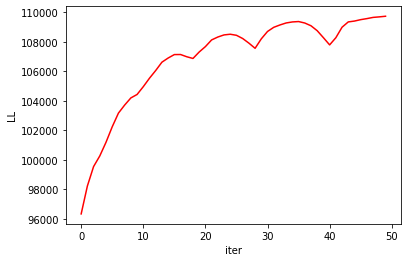

In [50]:
plt.plot(ls, 'r'); plt.xlabel("iter"); plt.ylabel("LL"); plt.show()

In [51]:
Theta

{'is_delta': tensor([-0.0513, -2.9957], dtype=torch.float64),
 'is_pi': tensor([-1.2092, -0.9423, -2.1012, -2.1420, -1.9395, -3.7162, -2.3293, -2.4355],
        dtype=torch.float64, requires_grad=True),
 'is_tau': tensor([[-7.1715, -3.4151, -3.2625, -3.8616, -3.9822, -3.0683, -2.8349, -4.1935],
         [-3.4151, -5.9369, -2.7468, -3.6875, -3.1361, -3.0228, -3.1750, -3.7729],
         [-3.2625, -2.7468, -7.0026, -3.5425, -3.0911, -3.8740, -3.9104, -5.1853],
         [-3.8616, -3.6875, -3.5425, -6.2379, -4.4637, -3.8776, -4.1997, -4.9321],
         [-3.9822, -3.1361, -3.0911, -4.4637, -5.8976, -4.2969, -5.0643, -4.4445],
         [-3.0683, -3.0228, -3.8740, -3.8776, -4.2969, -7.0463, -3.5620, -4.3239],
         [-2.8349, -3.1750, -3.9104, -4.1997, -5.0643, -3.5620, -6.4708, -4.6090],
         [-4.1935, -3.7729, -5.1853, -4.9321, -4.4445, -4.3239, -4.6090, -7.0988]],
        dtype=torch.float64, requires_grad=True),
 'log_mu': tensor([[-2.9024e+00, -1.4156e+00, -2.5798e+00, -7.5388e-01, 

In [52]:
with torch.no_grad():
  r,v, L, p_singlet = compute_r_v_2(Y,S,Theta)

p_singlet = p_singlet.numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


(array([544.,  14.,  10.,   5.,   2.,   8.,   8.,  10.,  14., 385.]),
 array([0.        , 0.09999663, 0.19999327, 0.2999899 , 0.39998654,
        0.49998317, 0.5999798 , 0.69997644, 0.79997307, 0.89996971,
        0.99996634]),
 <a list of 10 Patch objects>)

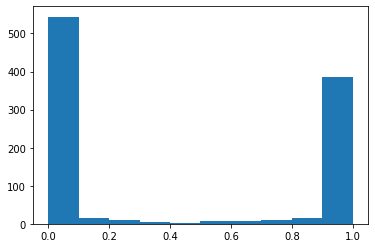

In [53]:
plt.hist(p_singlet)

In [54]:
adata.obs['p_singlet'] = p_singlet

Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [55]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)


In [56]:
sc.tl.umap(adata)



In [57]:
adata.obs

,Area,Eccentricity,EulerNumber,Extent,MajorAxisLength,MinorAxisLength,Nd145Di Twist,Number_Neighbors,Orientation,Percent_Touching,Perimeter,Solidity,p_singlet
cell_id,,,,,,,,,,,,,
BaselTMA_SP42_174_X9Y6_2279,114.0,0.402029,1.0,0.797203,12.781835,11.703393,0.096678,6.0,-76.279610,1.000000,39.118000,0.926829,9.999494e-01
BaselTMA_SP41_52_X9Y3_1654,72.0,0.591094,1.0,0.600000,11.314453,9.126265,0.206414,4.0,-4.429893,0.794872,32.592999,0.857143,9.985722e-01
BaselTMA_SP42_240_X9Y2_1604,65.0,0.349473,1.0,0.650000,9.670779,9.061002,0.203930,1.0,87.031288,0.485714,27.639000,0.942029,9.996400e-01
BaselTMA_SP41_58_X16Y1_169,170.0,0.757846,1.0,0.639098,18.609669,12.141579,0.125753,2.0,-67.730446,0.426230,49.737000,0.928962,9.901344e-01
BaselTMA_SP42_182_X1Y8_1361,51.0,0.899075,1.0,0.607143,12.572632,5.504223,0.203030,2.0,17.362230,0.757576,29.011999,0.927273,2.775834e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
BaselTMA_SP43_269_X5Y9_3287,14.0,0.858501,1.0,0.777778,6.067987,3.111740,0.178719,2.0,9.844302,1.000000,11.421000,0.933333,9.998860e-01
BaselTMA_SP42_127_X2Y8_1257,52.0,0.780778,1.0,0.650000,10.805151,6.751155,0.143808,9.0,35.204811,1.000000,26.389999,0.896552,2.080759e-01
BaselTMA_SP43_111_X8Y6_4234,98.0,0.755265,1.0,0.538462,15.442402,10.121245,0.291497,8.0,58.471760,1.000000,43.988998,0.777778,9.995147e-01


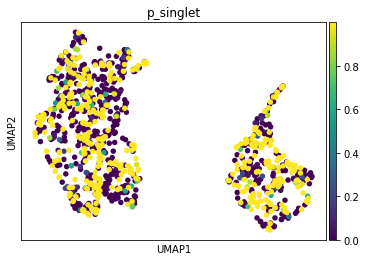

In [58]:
sc.pl.umap(adata, color = ['p_singlet'])

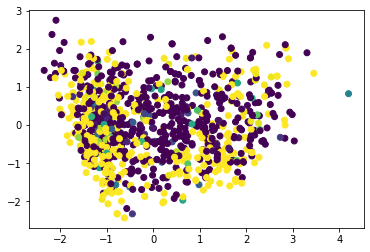

In [59]:
plt.scatter(Z[:,0], Z[:,1], c = p_singlet);

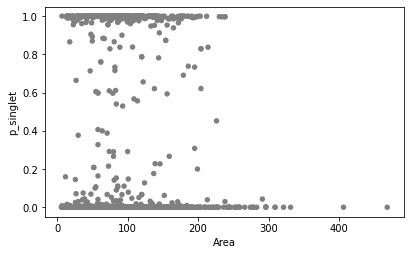

In [60]:
sc.pl.scatter(adata, x = 'Area', y = 'p_singlet')

In [61]:
adata.obs['probability_single_cell'] = adata.obs.p_singlet

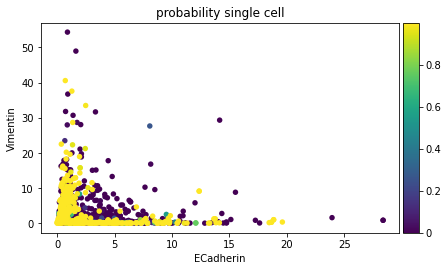

In [62]:
sc.pl.scatter(adata, x = 'ECadherin', y = 'Vimentin', color = 'probability_single_cell')

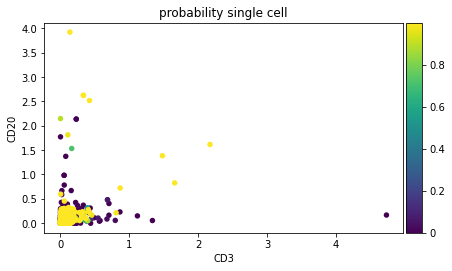

In [63]:
sc.pl.scatter(adata, x = 'CD3', y = 'CD20', color = 'probability_single_cell')

In [64]:
adata.var_names

Index(['EGFR', '10311239Ru96Di Rutheni', '10311240Ru98Di Rutheni',
       '10311241Ru99Di Rutheni', '10311242Ru100Di Rutheni',
       '10311243Ru101Di Rutheni', '10311244Ru102Di Rutheni',
       '10311245Ru104Di Rutheni', 'ECadherin', 'DNA1', 'DNA2', 'ER', 'GATA3',
       'Histone_H3_1', 'Ki67', 'SMA', 'Vimentin', 'cleaved_Parp', 'Her2',
       'p53', 'panCytokeratin', 'CD19', 'PR', 'Myc', 'Fibronectin', 'CK14',
       'Slug', 'CD20', 'vWF', 'Histone_H3_2', 'CK5', 'CD44', 'CD45', 'CD68',
       'CD3', 'CAIX', 'CK8/18', 'CK7', '80ArArArAr80Di', 'Hg202 202HgHg202Di',
       'I127 127II127Di', 'In115 115InIn115Di', 'Pb204 204PbPb204Di',
       'Pb206 206PbPb206Di', 'Pb207 207PbPb207Di', 'Pb208 208PbPb208Di',
       'Xe126 126XeXe126Di', 'Xe131 131XeXe131Di', 'Xe134 134XeXe134Di',
       'phospho Histone', 'phospho S6', 'phospho mTOR'],
      dtype='object', name='new')

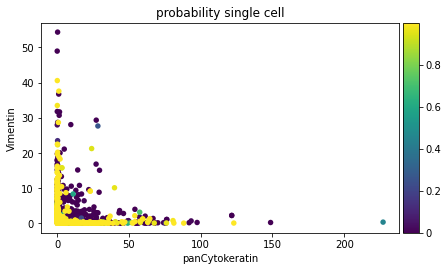

In [65]:
sc.pl.scatter(adata, x = 'panCytokeratin', y = 'Vimentin', color = 'probability_single_cell')

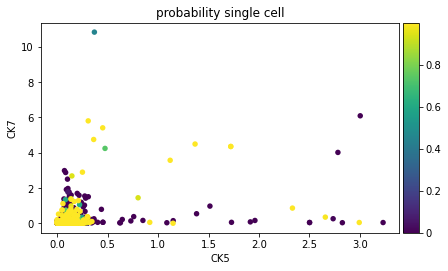

In [66]:
sc.pl.scatter(adata, x = 'CK5', y = 'CK7', color = 'probability_single_cell')

In [67]:
cell_sizes = np.exp(Theta['log_psi'].detach().numpy())
cell_sizes

array([91.9648928 , 82.41730181, 48.75472356, 62.44914852, 70.88324131,
       31.28429527, 78.38901988, 80.55568968])

In [68]:
F.softmax(Theta['is_delta'], dim=0)

tensor([0.9500, 0.0500], dtype=torch.float64)

In [69]:
mu_true

mu_inferred = torch.exp(Theta['log_mu'].detach()).numpy()

NameError: ignored

In [ ]:
sns.heatmap(np.corrcoef(mu_true, mu_inferred)[0:5,5:])


In [ ]:
sns.heatmap(np.corrcoef(mu_true, mu_init)[0:5,5:])

In [ ]:
vv = v.detach().numpy()
sns.heatmap(np.exp(vv[df_singlet.p_singlet.argmin(),:,:]))